# Hypertension Detection From High-Dimensional Representation of Photoplethysmogram (PPG) Signals

Accepted at IEEE-EMBS International Conference on Biomedical and Health Informatics (BHI’23)

Hypertension is commonly referred to as the "silent killer", since it can lead to severe health complications without any visible symptoms. Early detection of hypertension is crucial in preventing significant health issues. Although some studies suggest a relationship between blood pressure and certain vital signals, such as Photoplethysmogram (PPG), reliable generalization of the proposed blood pressure estimation methods is not yet guaranteed. This lack of certainty has resulted in some studies doubting the existence of such relationships, or considering them weak and limited to heart rate and blood pressure. In this work, a high-dimensional representation technique based on random convolution kernels is proposed for hypertension detection using PPG signals. The results show that this relationship extends beyond heart rate and blood pressure, demonstrating the feasibility of hypertension detection with generalization on unseen subjects. Additionally, the utilized transform using convolution kernels, as an end-to-end time-series feature extractor, outperforms the methods proposed in the previous studies and state-of-the-art deep learning models.

This notebook provides the code for training and testing a model to detect hypertension from PPG signals using random convolution kernels (MiniROCKET).

[Paper: arXiv:2308.02425](https://arxiv.org/abs/2308.02425)


Please use the following citation:

```bibtex
@misc{hasanzadeh2023hypertension,
      title={Hypertension Detection From High-Dimensional Representation of Photoplethysmogram Signals}, 
      author={Navid Hasanzadeh and Shahrokh Valaee and Hojjat Salehinejad},
      year={2023},
      eprint={2308.02425},
      archivePrefix={arXiv},
      primaryClass={eess.SP}
}
```



## Parameters

In [1]:
# The ratio of the training set (with 1 million samples) that will be used for training the models.
# Values near 1.0 -> Take longer and require more RAM (1.0 requires about 400GB), but yield higher accuracy.
# See our paper for more details.
training_data_ratio = 0.10
# The dataset location
train_records_adr = "train/*.tfrecord"
test_records_adr = "test/*.tfrecord"

## Importing Libraries

In [2]:
import h5py
import tensorflow as tf
from pyampd.ampd import find_peaks
import glob
from tqdm import tqdm
import numpy as np

## Preparing and Loading Dataset

In this study, the PPG signals and corresponding BPs derived from the MIMIC-III dataset are used. The BP values are categorized into normal and hypertension classes based on ESC/ESH guidelines. This dataset comprises $3750$ subjects for training and $625$ subjects for testing. The training and test datasets are standardized and divided at subject level to avoid any overlap. There are $1,000,000$ PPG signals for training, $250,000$ samples for validation, and $250,000$ samples for testing. Each PPG sample has a duration of $7$ seconds, and the sampling rate is $125$ Hz. 


The dataset can be downloaded from :

https://zenodo.org/record/5590603/files/MIMIC-III_ppg_dataset.h5?download=1.

The size of the dataset is approximately 32 GB. You need to convert the h5 file to tfrecords using h5_to_tfrecord.py:

https://github.com/Fabian-Sc85/non-invasive-bp-estimation-using-deep-learning/tree/main

In [3]:
def get_hypertension_label(sysBP,diaBP):
    if(sysBP<120 and diaBP<80):
        return 0
    if((sysBP>=120 and sysBP<=129) or (diaBP>=80 and diaBP<=84)):
        return 0
    if((sysBP>=130 and sysBP<=139) or (diaBP>=85 and diaBP<=89)):
        return 0
    if((sysBP>=140 and sysBP<=159) or (diaBP>=90 and diaBP<=99)):
        return 1
    if((sysBP>=160 and sysBP<=179) or (diaBP>=100 and diaBP<=109)):
        return 1
    if(sysBP>=180 or diaBP>110):
        return 1    
    return 1

In [4]:
def get_mimiciii_record(filename, fs=125):
  raw_dataset = tf.data.TFRecordDataset([filename])
  dset = raw_dataset.take(count=1000)
  example = tf.train.Example()
  dset_list = list(dset)
  ppg_records = []
  sys_records = []
  dia_records = []
  bp_records = []
  hr_records = []
  for i in range(len(list(dset))):
    element = dset_list[i]
    example.ParseFromString(element.numpy())
    ppg = np.array(example.features.feature['ppg'].float_list.value)
    ppg = ppg - np.mean(ppg)
    ppg = ppg / np.std(ppg)
    sys = np.max(example.features.feature['label'].float_list.value)
    dia = np.min(example.features.feature['label'].float_list.value)
    onsets = find_peaks(ppg) # using AMPD algorithm for peak detection
    hr = np.round(fs / (0.00001 + np.median(np.diff(onsets))) * 60,0)
    hr_records.append(hr)
    ppg_records.append(ppg)
    sys_records.append(sys)
    dia_records.append(dia)
    bp_records.append(get_hypertension_label(sys,dia))
  return ppg_records, sys_records, dia_records, hr_records, bp_records

In [5]:
def create_mimiciii_dataset(address):
    adr_all = glob.glob(address)
    bp_classes = []
    ppg_all = []
    hr_all = []
    for adr in tqdm(adr_all):
        ppg_records, sys_records, dia_records, hr_records, bp_records = get_mimiciii_record(adr)
        ppg_all.extend(ppg_records)
        bp_classes.extend(bp_records)
        hr_all.extend(hr_records)
    return ppg_all, hr_all, bp_classes

In [6]:
X_train, X_HR_train, y_train = create_mimiciii_dataset(train_records_adr)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:14:58<00:00,  4.50s/it]


In [7]:
X_test, X_HR_test, y_test = create_mimiciii_dataset(test_records_adr)

 94%|███████████████████████████████████████████████████████████████████████████▌    | 236/250 [17:37<01:10,  5.04s/it]C:\Users\16478\anaconda3\envs\keras_gpu\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\16478\anaconda3\envs\keras_gpu\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [18:47<00:00,  4.51s/it]


In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_HR_train = np.array(X_HR_train).reshape(-1,1)
X_HR_test = np.array(X_HR_test).reshape(-1,1)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("X_HR_train: ", X_HR_train.shape)
print("X_HR_test: ", X_HR_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (1000000, 875)
X_test:  (250000, 875)
X_HR_train:  (1000000, 1)
X_HR_test:  (250000, 1)
y_train:  (1000000,)
y_test:  (250000,)


#### The histogram of the training set

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

([<matplotlib.axis.XTick at 0x1be60ea4550>,
 [Text(0, 0, 'Normal'), Text(1, 0, 'Hypertension')])

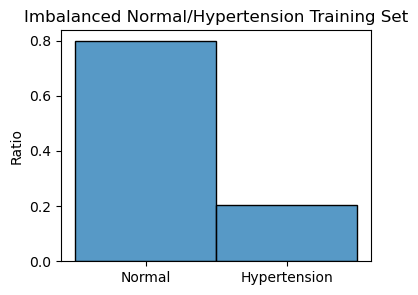

In [11]:
plt.figure(figsize=(4,3))
sn.histplot(
    data=y_train,   
    discrete=True,
    stat='probability'
)
plt.ylabel('Ratio')
plt.title("Imbalanced Normal/Hypertension Training Set")
plt.xticks([0,1], ['Normal','Hypertension'])

#### A sample of PPG in the training set

Text(0.5, 0, 'Sample')

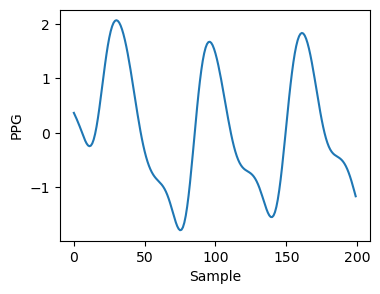

In [12]:
plt.figure(figsize=(4,3))
plt.plot(X_train[600][0:200])
plt.ylabel("PPG")
plt.xlabel("Sample")

## Feature Extraction using MiniROCKET

In [13]:
from minirocket_multivariate import fit
from minirocket_multivariate import transform

In [14]:
X_train_part = X_train[:int(training_data_ratio*len(X_train))]
y_train_part = y_train[:int(training_data_ratio*len(y_train))]

In [15]:
X_test = X_test[:,np.newaxis,:]
X_train_part = X_train_part[:,np.newaxis,:]

In [16]:
print("X_train_part: ", X_train_part.shape)
print("X_test: ", X_test.shape)

X_train_part:  (100000, 1, 875)
X_test:  (250000, 1, 875)


In [17]:
X_train_part = X_train_part.astype(np.float32)
X_test = X_test.astype(np.float32)

In [18]:
parameters = fit(X_train_part, num_features=10000)
X_training_transform = transform(X_train_part, parameters)

In [19]:
X_test_transform = transform(X_test, parameters)

In [35]:
X_training_minirocket = X_training_transform
X_test_minirocket = X_test_transform

In [36]:
X_train_mean = X_training_minirocket.mean(0)
X_train_std = X_training_minirocket.std(0)


X_train_minirocket = X_training_minirocket -X_train_mean
X_train_minirocket = X_train_minirocket / (X_train_std + 0.00001)


X_test_minirocket = X_test_minirocket - X_train_mean
X_test_minirocket = X_test_minirocket / (X_train_std + 0.00001)

## Training and Testing Models

In [22]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

### Model: Heart-rate + RidgeClassifierCV

In [37]:
X_HR_train_part = X_HR_train[:int(training_data_ratio*len(y_train))]

In [41]:
# Remove NaNs
col_mean = np.nanmean(X_HR_train_part, axis=0)
inds = np.where(np.isnan(X_HR_train_part))
X_HR_train_part[inds] = np.take(col_mean, inds[1])
inds = np.where(np.isnan(X_HR_test))
X_HR_test[inds] = np.take(col_mean, inds[1])

In [42]:
clf = RidgeClassifierCV(class_weight="balanced")

In [43]:
clf.fit(X_HR_train_part, y_train_part)

RidgeClassifierCV(class_weight='balanced')

In [44]:
predictions = clf.predict(X_HR_test)
accuracy = np.mean(predictions==y_test)

In [45]:
print("Results (using {}% of training set)".format(training_data_ratio*100))
print(classification_report(y_test,predictions, target_names=['Normal', 'Hypertension']))

Results (using 10.0% of training set)
              precision    recall  f1-score   support

      Normal       0.79      0.50      0.61    195972
Hypertension       0.22      0.53      0.32     54028

    accuracy                           0.50    250000
   macro avg       0.51      0.51      0.46    250000
weighted avg       0.67      0.50      0.55    250000



Model: HR + RidgeClassifierCV - using 10.0% of training set


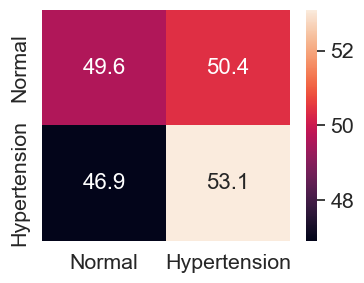

In [46]:
matrix = confusion_matrix(y_test, predictions, labels=[0,1]).astype(np.float32)
s = matrix.sum(axis=1)
for i in range(2):
    matrix[i,:]=matrix[i,:] /s[i]
matrix = np.round(matrix,3)  * 100
df_cm = pd.DataFrame(matrix, ['Normal', 'Hypertension'], ['Normal', 'Hypertension'])
plt.figure(figsize=(4,3))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.1f') # font size
print("Model: HR + RidgeClassifierCV - using {}% of training set".format(training_data_ratio*100))
plt.show()

### Model: MiniROCKET + BalancedRandomForestClassifier

In [47]:
clf = BalancedRandomForestClassifier(n_estimators=100, n_jobs=-1)

In [48]:
clf.fit(X_train_minirocket, y_train_part)

BalancedRandomForestClassifier(n_jobs=-1)

In [49]:
predictions = clf.predict(X_test_minirocket)
accuracy = np.mean(predictions==y_test)

In [50]:
print("Results (using {}% of training set)".format(training_data_ratio*100))
print(classification_report(y_test,predictions, target_names=['Normal', 'Hypertension']))

Results (using 10.0% of training set)
              precision    recall  f1-score   support

      Normal       0.87      0.65      0.75    195972
Hypertension       0.34      0.66      0.45     54028

    accuracy                           0.65    250000
   macro avg       0.61      0.65      0.60    250000
weighted avg       0.76      0.65      0.68    250000



Model: MiniROCKET + BalancedRandomForestClassifier - using 10.0% of training set


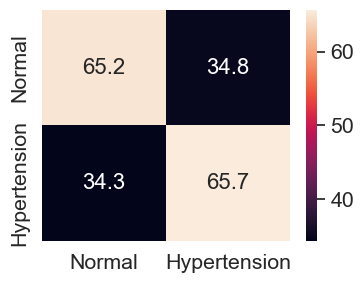

In [51]:
matrix = confusion_matrix(y_test, predictions, labels=[0,1]).astype(np.float32)
s = matrix.sum(axis=1)
for i in range(2):
    matrix[i,:]=matrix[i,:] /s[i]
matrix = np.round(matrix,3)  * 100
df_cm = pd.DataFrame(matrix, ['Normal', 'Hypertension'], ['Normal', 'Hypertension'])
plt.figure(figsize=(4,3))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.1f') # font size
print("Model: MiniROCKET + BalancedRandomForestClassifier - using {}% of training set".format(training_data_ratio*100))
plt.show()